In [1]:
import pandas as pd

df = pd.read_parquet("../data/processed/feature_engineered.parquet")

target = "fail_in_7_days"

drop_cols = [
    target,
    "failure",
    "date",
    "serial_number",
    "model",
    "capacity_bytes",
    "fail_date"
]

X = df.drop(columns=drop_cols)
y = df[target]

for col in ["smart_187_raw", "smart_188_raw"]:
    X[col + "_missing"] = X[col].isna().astype(int)
X = X.fillna(0)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [3]:
import joblib

rf_model = joblib.load("../models/rf_model.pkl")
xgb_model = joblib.load("../models/xgb_model.pkl")

y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [4]:
from sklearn.metrics import roc_auc_score, average_precision_score

print("RF ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("XGB ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

print("RF PR-AUC:", average_precision_score(y_test, y_proba_rf))
print("XGB PR-AUC:", average_precision_score(y_test, y_proba_xgb))


RF ROC-AUC: 0.8243277529923492
XGB ROC-AUC: 0.9655398742044705
RF PR-AUC: 0.11466623645397678
XGB PR-AUC: 0.48564294128162205


In [5]:
import numpy as np
from sklearn.metrics import classification_report

def evaluate_top_pct(y_true, y_proba, pct):
    k = int(len(y_proba) * pct)
    idx = np.argsort(y_proba)[::-1][:k]
    y_pred = np.zeros_like(y_proba)
    y_pred[idx] = 1
    print(classification_report(y_true, y_pred))

print("RF Top 1%")
evaluate_top_pct(y_test.values, y_proba_rf, 0.01)

print("XGB Top 1%")
evaluate_top_pct(y_test.values, y_proba_xgb, 0.01)

RF Top 1%
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    644644
           1       0.01      0.65      0.02        75

    accuracy                           0.99    644719
   macro avg       0.50      0.82      0.51    644719
weighted avg       1.00      0.99      0.99    644719

XGB Top 1%
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    644644
           1       0.01      0.69      0.02        75

    accuracy                           0.99    644719
   macro avg       0.50      0.84      0.51    644719
weighted avg       1.00      0.99      0.99    644719



<Figure size 800x600 with 0 Axes>

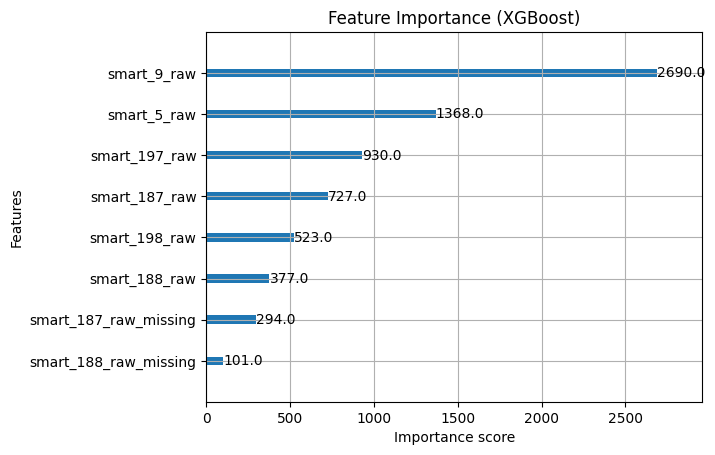

In [7]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(8,6))
plot_importance(xgb_model, max_num_features=10)
plt.title("Feature Importance (XGBoost)")
plt.show()